Week 11 · Day 4 — Multi-Head Attention in PyTorch
Why this matters

Multi-head attention is what makes Transformers powerful. Instead of one attention pattern, the model learns several parallel “views” (heads), each focusing on different relationships. This lets the model capture richer dependencies.

Theory Essentials

Single-head: one set of Q, K, V projections → one attention map.

Multi-head:

Linear layers project input into multiple Q, K, V spaces.

Each head runs scaled dot-product attention.

Outputs are concatenated + projected back.

Benefit: captures multiple relationships (e.g., syntax vs meaning).

In [ ]:
# Setup
import torch, torch.nn as nn, torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Final output projection
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, Q, K, V, mask=None):
        B, L, _ = Q.shape  # Batch, Seq_len, d_model
        
        # Project and split into heads
        Q = self.W_q(Q).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(K).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(V).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        
        # Scaled dot-product attention
        scores = (Q @ K.transpose(-2,-1)) / (self.d_k ** 0.5)  # (B, heads, L, L)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = F.softmax(scores, dim=-1)
        
        out = attn @ V  # (B, heads, L, d_k)
        
        # Concatenate heads
        out = out.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.W_o(out), attn

# Example usage
torch.manual_seed(42)
mha = MultiHeadAttention(d_model=16, num_heads=4)

x = torch.randn(2, 5, 16)  # batch=2, seq_len=5, d_model=16
out, attn = mha(x, x, x)   # self-attention

print("Output shape:", out.shape)   # (2, 5, 16)
print("Attention shape:", attn.shape)  # (2, 4, 5, 5) batch × heads × query × key



### Step 1: Single head recap

Imagine we have a sentence:
**“The cat sat”**

Each word is an **embedding vector**. Say embedding dim = 6.

For **single head attention**:

* We project these embeddings into Q, K, V (each dim = 6).
* For the query “sat”:

  * Compare Q(sat) with K(the), K(cat), K(sat).
  * Suppose weights = \[0.1, 0.7, 0.2].
  * Mix the values → output(sat).

So one head produces **one set of weights + one output vector per token**.

---

### Step 2: Multi-head setup

Now suppose we use **2 heads**, each of size 3 (so 3+3 = 6 total dim).

* **Head 1** has its own learned projection matrices $W^Q_1, W^K_1, W^V_1$.
* **Head 2** has different matrices $W^Q_2, W^K_2, W^V_2$.
* Both take the same input embeddings, but project them differently → so they produce *different* Q/K/V.

---

### Step 3: What happens for “sat”

* **Head 1:**

  * Q₁(sat) compares with K₁(the), K₁(cat), K₁(sat).
  * Maybe weights = \[0.1, 0.8, 0.1] (focuses on “cat”).
  * Output₁(sat) = weighted mix of V₁(the,cat,sat).

* **Head 2:**

  * Q₂(sat) compares with K₂(the), K₂(cat), K₂(sat).
  * Maybe weights = \[0.6, 0.2, 0.2] (focuses on “the”).
  * Output₂(sat) = weighted mix of V₂(the,cat,sat).

Now you have **two different perspectives** of “sat”:

* Head 1 says: “Sat is mostly about *cat*.”
* Head 2 says: “Sat is also tied to *the*.”

---

### Step 4: Combine

* The outputs from all heads are concatenated: `[Output₁(sat) | Output₂(sat)]`.
* A final linear layer squashes them back into one vector of dim=6.

So “sat” now has a richer representation that mixes **multiple relationships**.

---

✅ **Key takeaway:**

* Each head has its own Q, K, V (from different projections).
* They all answer the *same query token*, but in different “attention spaces.”
* Purpose = let the model capture multiple kinds of relationships at once.






### 1. Same starting point

* The embedding for **“sat”** is a vector (say, size 512).
* That embedding captures the general meaning of the word.
* This embedding is shared across all heads.

So all heads *start from the same base meaning*.

---

### 2. Different projections = different perspectives

* Each head applies a different learned linear transformation.
* Mathematically, that just means multiplying the same vector by a different matrix.
* Conceptually: each projection **emphasizes different features** of the same embedding.

👉 Example:

* Embedding(“sat”) = `[0.9, -0.2, 1.1]`
* Head 1’s projection might highlight syntax features (subject–verb).
* Head 2’s projection might highlight semantic features (action vs object).

So both still represent “sat,” but **with different aspects emphasized**.

---

### 3. What they have in common

What ties them together is:

* They all come from the same original embedding of “sat.”
* Each projection is *linear* → so the information is preserved but “rotated/scaled” differently.
* After attention, all heads’ outputs are concatenated and then passed through another linear layer, which **recombines them back into one unified representation**.

So the model sees:

* Head 1: “sat” in relation to “cat.”
* Head 2: “sat” in relation to “the.”
* … and merges both into a single updated embedding of “sat.”

---

### 4. Analogy

Imagine you take one photo of a cat:

* Head 1: applies a **red filter** → highlights fur.
* Head 2: applies a **blue filter** → highlights eyes.
* They look different, but both are based on the **same original photo**.
* At the end, you can merge them back to get a richer picture.

---

✅ **Answer to your question:**

* Yes, the embedding vector for “sat” is the same at the start.
* Each head projects it differently, but that’s just “looking at the same word through different lenses.”
* At the end, the Transformer combines all the heads, so you don’t lose the identity of “sat” — instead, you enrich it with multiple perspectives.



### 1. At the start, it *is* random

* The projection matrices $W^Q, W^K, W^V$ for each head are initialized randomly.
* So in the very first steps, the heads’ outputs are basically random projections of the embeddings.
* Nothing “makes sense” yet.

---

### 2. Training makes it meaningful

* During training, the model predicts outputs (e.g. next word in GPT) and compares to the real target.
* The **loss function** (cross-entropy) measures error.
* Backpropagation updates all the weights (including the Q/K/V projection matrices).
* Over millions of training examples, the heads adjust so that their different projections actually help minimize the loss.

So:

* Head 1’s matrices gradually learn to highlight patterns useful for syntax.
* Head 2’s matrices learn to highlight patterns useful for semantics.
* But that specialization is not manually assigned — it emerges because it improves performance.

---

### 3. Why linear transformations aren’t “just random noise”

* A linear transformation is not just random chopping — it’s a *structured way* of rotating and scaling the embedding space.
* Because the weights are trainable, the network **discovers useful rotations/scalings** that separate out different features.
* Example: one head might rotate the embedding space so subject–verb relations become easier to spot.

---

### 4. How we know it works

We can inspect trained models (like BERT, GPT). Researchers visualize attention heads and find:

* Some heads consistently track **subject → verb**.
* Others track **noun → adjective**.
* Others link **coreferences** (e.g., “Alice … she”).
* So even though all started random, training nudged them into meaningful specializations.

---

✅ **Answer to your doubt:**

* Yes, the linear projections are random at first.
* They don’t stay random — they are **learned** during training to minimize the model’s loss.
* That’s why different heads end up focusing on different aspects of language, even though no one explicitly told them what to do.




### 1. Same principle as Week 1 (Titanic)

* In logistic regression, the trainable parts were **weights and bias** of a linear classifier.
* In attention, the trainable parts include the **projection matrices**:

  * $W^Q$ (for queries),
  * $W^K$ (for keys),
  * $W^V$ (for values),
    for each head.
* Backpropagation adjusts these matrices so that the model’s predictions improve.

So yes — the principle is the same, just applied to different kinds of parameters.

---

### 2. Can heads overlap?

Yes ✅

* Nothing forces the heads to specialize in unique roles.
* Head 1 and Head 3 could both learn similar “syntax-like” attention patterns.
* In practice, some redundancy *does* happen.

But:

* Because of the size of the model and the diversity of data, many heads drift toward **different specializations** (syntax, semantics, coreference, positional patterns, etc.).
* Even when a couple of heads overlap, having multiple heads still improves robustness — like having two detectives checking the same clue.

---

### 3. Why this works in practice

* Start: heads = random projections.
* Training: gradient descent nudges each head’s projections in directions that reduce loss.
* End: some heads converge to similar roles, others to distinct ones, and together they give the model **multiple “views” of the sequence**.

---


In [ ]:
# Setup
import torch, torch.nn as nn, torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model # embedding dimension
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # per-head dimension
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Final output projection
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, Q, K, V, mask=None):
        B, L, _ = Q.shape  # Batch, Seq_len, d_model
        
        # Project and split into heads
        Q = self.W_q(Q).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(K).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(V).view(B, L, self.num_heads, self.d_k).transpose(1,2)
        
        # Scaled dot-product attention
        scores = (Q @ K.transpose(-2,-1)) / (self.d_k ** 0.5)  # (B, heads, L, L)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = F.softmax(scores, dim=-1)
        
        out = attn @ V  # (B, heads, L, d_k)
        
        # Concatenate heads
        out = out.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.W_o(out), attn

# Example usage
torch.manual_seed(42)
mha = MultiHeadAttention(d_model=16, num_heads=4)

x = torch.randn(2, 5, 16)  # batch=2, seq_len=5, d_model=16
out, attn = mha(x, x, x)   # self-attention

print("Output shape:", out.shape)   # (2, 5, 16)
print("Attention shape:", attn.shape)  # (2, 4, 5, 5) batch × heads × query × key


Output shape: torch.Size([2, 5, 16])
Attention shape: torch.Size([2, 4, 5, 5])


You instantiated mha = MultiHeadAttention(d_model=16, num_heads=4).

You created fake data x = random embeddings of 2 sequences, each 5 tokens long.

You ran mha(x, x, x) → meaning: “run self-attention on this batch of embeddings.”

Output:

out = updated embeddings of shape (2, 5, 16)

attn = attention weight matrices (2, 4, 5, 5)

1) Core (10–15 min)
Task: Run with num_heads=2 and num_heads=8. What changes in the shape of attention weights?

In [2]:
for h in [2,8]:
    mha = MultiHeadAttention(16, h)
    out, attn = mha(x,x,x)
    print(f"Heads={h}, attn shape={attn.shape}")


Heads=2, attn shape=torch.Size([2, 2, 5, 5])
Heads=8, attn shape=torch.Size([2, 8, 5, 5])


Only the head dimension changes

2) Practice (10–15 min)
Task: Apply a padding mask so that the last 2 tokens are ignored.

In [3]:
mask = torch.ones(2,1,1,5)   # broadcast across heads
mask[:,:,:,3:] = 0           # mask last 2 tokens
out, attn = mha(x,x,x,mask)
print(attn[0])  # check first batch


tensor([[[0.3411, 0.3183, 0.3406, 0.0000, 0.0000],
         [0.3594, 0.3097, 0.3309, 0.0000, 0.0000],
         [0.3490, 0.2810, 0.3700, 0.0000, 0.0000],
         [0.2970, 0.3976, 0.3054, 0.0000, 0.0000],
         [0.3717, 0.3128, 0.3155, 0.0000, 0.0000]],

        [[0.3672, 0.3139, 0.3189, 0.0000, 0.0000],
         [0.3105, 0.3278, 0.3617, 0.0000, 0.0000],
         [0.3694, 0.3977, 0.2330, 0.0000, 0.0000],
         [0.4014, 0.4694, 0.1292, 0.0000, 0.0000],
         [0.2648, 0.2283, 0.5069, 0.0000, 0.0000]],

        [[0.3119, 0.3024, 0.3857, 0.0000, 0.0000],
         [0.3328, 0.2998, 0.3675, 0.0000, 0.0000],
         [0.2300, 0.4326, 0.3374, 0.0000, 0.0000],
         [0.2701, 0.2875, 0.4424, 0.0000, 0.0000],
         [0.2110, 0.4289, 0.3601, 0.0000, 0.0000]],

        [[0.1507, 0.2998, 0.5494, 0.0000, 0.0000],
         [0.1548, 0.2752, 0.5700, 0.0000, 0.0000],
         [0.1194, 0.2734, 0.6072, 0.0000, 0.0000],
         [0.2039, 0.3079, 0.4882, 0.0000, 0.0000],
         [0.0972, 0.2843,

3) Stretch (optional, 10–15 min)
Task: Visualize attention maps for one head with matplotlib.imshow.
Hint: Pick attn[0,0] (batch 0, head 0).

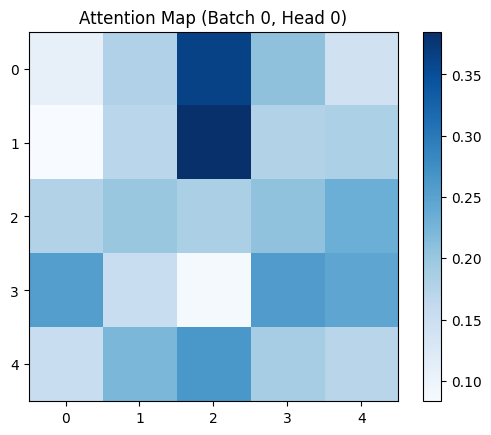

In [5]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
mha = MultiHeadAttention(d_model=16, num_heads=4)

x = torch.randn(2, 5, 16)  # batch=2, seq_len=5, d_model=16
out, attn = mha(x, x, x)   # self-attention

plt.imshow(attn[0,0].detach(), cmap="Blues")
plt.colorbar()
plt.title("Attention Map (Batch 0, Head 0)")
plt.show()


Mini-Challenge (≤40 min)

Build: A reusable MultiHeadAttention module where you can:

Pass in any (batch, seq_len, d_model) tensor.

Choose number of heads.

Optionally add a mask.

Visualize attention weights for each head.

Acceptance Criteria:

Clean PyTorch module.

Works with/without mask.

Heatmap visualization shows different heads focusing differently.

No-mask out shape: torch.Size([2, 6, 16])
No-mask attn shape: torch.Size([2, 4, 6, 6])


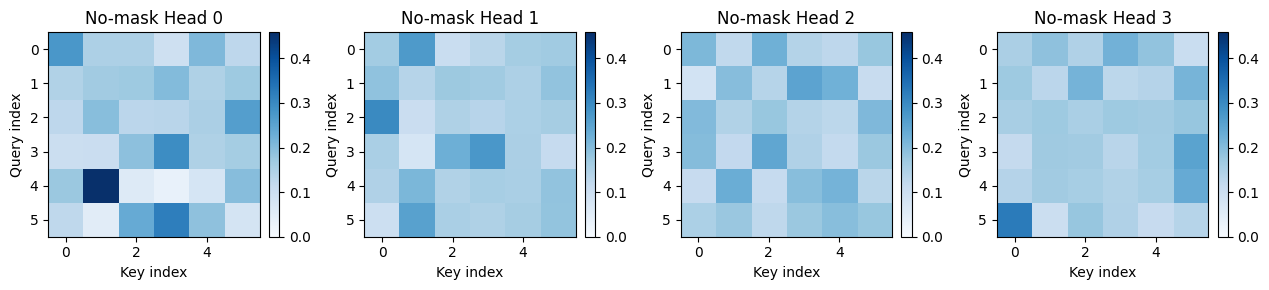

Padding-mask out shape: torch.Size([2, 6, 16])


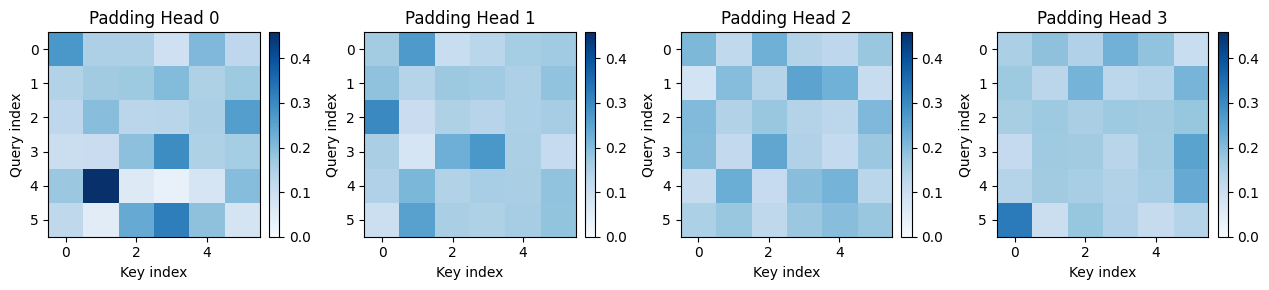

Causal-mask out shape: torch.Size([2, 6, 16])


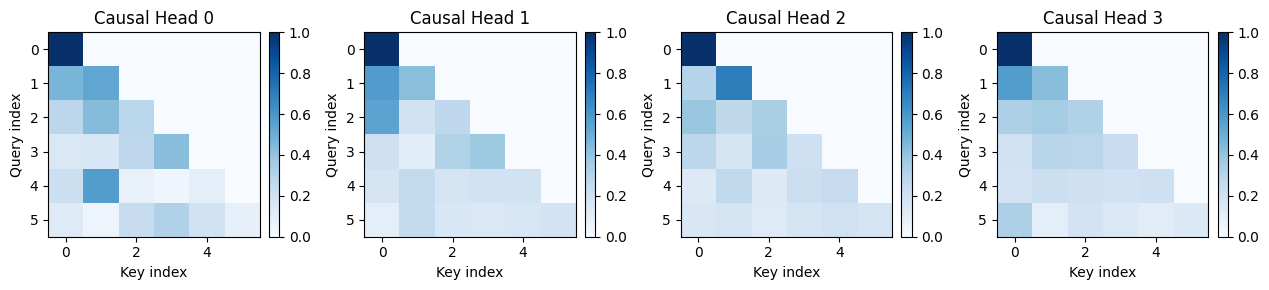

In [6]:
# Mini-Challenge: Reusable Multi-Head Attention (CPU-friendly)
# ------------------------------------------------------------
# Build: pass any (batch, seq_len, d_model) tensor; choose #heads; optional mask;
# visualize per-head attention.

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt

torch.manual_seed(42)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Learned projections (one big linear each, then we split into heads)
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # Output projection (recombine heads)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor,
                mask: torch.Tensor | None = None):
        """
        Q, K, V: (B, L, d_model)
        mask: optional; broadcastable to (B, heads, L_q, L_k).
              1/True = keep, 0/False = block.
        Returns:
          out: (B, L, d_model)
          attn: (B, heads, L_q, L_k)
        """
        B, Lq, _ = Q.shape
        Lk = K.shape[1]

        # Linear projections
        Q = self.W_q(Q).view(B, Lq, self.num_heads, self.d_k).transpose(1, 2)  # (B, H, Lq, d_k)
        K = self.W_k(K).view(B, Lk, self.num_heads, self.d_k).transpose(1, 2)  # (B, H, Lk, d_k)
        V = self.W_v(V).view(B, Lk, self.num_heads, self.d_k).transpose(1, 2)  # (B, H, Lk, d_k)

        # Scaled dot-product attention
        scores = (Q @ K.transpose(-2, -1)) / (self.d_k ** 0.5)                 # (B, H, Lq, Lk)

        if mask is not None:
            # mask==0 positions get a large negative score → softmax → ~0 prob
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)                                       # (B, H, Lq, Lk)
        out = attn @ V                                                         # (B, H, Lq, d_k)

        # Concat heads and project back
        out = out.transpose(1, 2).contiguous().view(B, Lq, self.d_model)       # (B, Lq, d_model)
        out = self.W_o(out)                                                    # (B, Lq, d_model)
        return out, attn

# ---- Mask helpers -----------------------------------------------------------

def causal_mask(batch_size: int, seq_len_q: int, seq_len_k: int, num_heads: int):
    """Lower-triangular (no peeking into the future). Shape: (B, H, Lq, Lk)"""
    base = torch.tril(torch.ones(seq_len_q, seq_len_k, dtype=torch.bool))
    return base.unsqueeze(0).unsqueeze(0).expand(batch_size, num_heads, seq_len_q, seq_len_k)

def padding_mask_from_lengths(lengths: torch.Tensor, max_len: int | None = None, num_heads: int = 1):
    """
    lengths: (B,) valid lengths per sequence
    Returns mask shaped (B, H, L, L) where keys beyond length are 0 (blocked).
    Use for self-attention (queries & keys same length L).
    """
    B = lengths.shape[0]
    L = int(max_len or lengths.max().item())
    # Key mask (B, 1, 1, L)
    key_keep = torch.arange(L).expand(B, L) < lengths.unsqueeze(1)
    key_keep = key_keep.unsqueeze(1).unsqueeze(1)  # (B,1,1,L)
    # Broadcast over heads and queries (queries are all valid up to L)
    return key_keep.expand(B, num_heads, L, L)

# ---- Visualization ----------------------------------------------------------

def visualize_attention(attn: torch.Tensor, title_prefix: str = "Head"):
    """
    attn: (B, H, Lq, Lk) → plots first item in batch, all heads.
    """
    attn_np = attn[0].detach().cpu().numpy()  # (H, Lq, Lk)
    H = attn_np.shape[0]
    fig, axes = plt.subplots(1, H, figsize=(3.2*H, 3))
    if H == 1: axes = [axes]
    for h in range(H):
        ax = axes[h]
        im = ax.imshow(attn_np[h], cmap="Blues", aspect="auto", vmin=0, vmax=attn_np.max())
        ax.set_title(f"{title_prefix} {h}")
        ax.set_xlabel("Key index")
        ax.set_ylabel("Query index")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# ---- Demo / Acceptance checks ----------------------------------------------

# Fake embeddings (batch=2, seq_len=6, d_model=16)
x = torch.randn(2, 6, 16)

mha = MultiHeadAttention(d_model=16, num_heads=4)

# 1) No mask (plain self-attention)
out_nomask, attn_nomask = mha(x, x, x)
print("No-mask out shape:", out_nomask.shape)       # (2, 6, 16)
print("No-mask attn shape:", attn_nomask.shape)     # (2, 4, 6, 6)
visualize_attention(attn_nomask, title_prefix="No-mask Head")

# 2) Padding mask example (second sequence is shorter)
lengths = torch.tensor([6, 4])                      # seq 0: full 6, seq 1: only first 4 valid
pad_mask = padding_mask_from_lengths(lengths, max_len=6, num_heads=4)  # (2,4,6,6)
out_pad, attn_pad = mha(x, x, x, mask=pad_mask)
print("Padding-mask out shape:", out_pad.shape)
visualize_attention(attn_pad, title_prefix="Padding Head")

# 3) Causal mask example (no future)
c_mask = causal_mask(batch_size=2, seq_len_q=6, seq_len_k=6, num_heads=4)      # (2,4,6,6)
out_causal, attn_causal = mha(x, x, x, mask=c_mask)
print("Causal-mask out shape:", out_causal.shape)
visualize_attention(attn_causal, title_prefix="Causal Head")


Notes / Key Takeaways

Multi-head = parallel attention “views.”

Each head has smaller dimensionality → more diverse patterns.

Concatenation lets the model combine info.

Attention shape: (batch, heads, queries, keys).

PyTorch module makes it reusable for Transformers later.

Reflection

Why is it better to have multiple smaller heads rather than one large head?

What’s the purpose of the final output projection (W_o) after concatenation?

Why multiple smaller heads instead of one large head?
Multiple heads let the model learn different attention patterns in parallel. One head might focus on short-range syntax (e.g., subject–verb), another on long-range dependencies (e.g., pronoun–noun), and another on semantic roles. A single large head could, in theory, represent all of this, but in practice it tends to collapse into one dominant pattern. Splitting into smaller heads encourages specialization and makes the model more expressive.

Purpose of the final output projection (W_o) after concatenation:
After concatenating all the heads, you get a big vector that is just the raw “stitching together” of each head’s perspective. The W_o linear layer mixes and compresses these into a single unified representation of the same dimension as the input (d_model). This ensures the model can pass the information forward consistently, and lets it learn how to best combine the different heads’ insights.